# Modules and Constants

In [1]:
# Mathematical operations
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors

# My own functions
from diffusion import *

In [2]:
# Natural constants
kB    = 1.3806485*10**-23  # Boltzmann constant [J/K]

# Simulation parameters
T     = 310

# Box properties and translational diffusion

In [3]:
new_box_data = np.loadtxt("simulations-ANT1-dilute/results-translation/dc_Protein.dat").T
print('number of new simulations:', new_box_data.shape[1])

number of new simulations: 66


In [4]:
new_box_edge   = new_box_data[0]
new_box_height = (new_box_data[1]-4.5)/2.0

# MSD and diffusion coefficients

In [5]:
numblocks = 10
fitstart  = 30
fitend    = 60 

In [6]:
new_msd = []
new_dc  = []
new_err = []

piece  = ['07','08','09','10','12','14','16','18','20','24','28']
letter = ['A','B','C','D','E','F']

# Iterate through the new data
for np_, p_ in enumerate(piece):
    for nl_, l_ in enumerate(letter):
        
        data = np.loadtxt('simulations-ANT1-dilute/results-rotation/Rotation_Protein_PC60PE40-PC50PE40CL10-1OKC-piece'+p_+'-mult01-'+l_+'.xvg',comments=['#','@']).T

        # The first column is time
        time = data[0]

        # overwrite the increments with their cumulative sum ( = total rotation in radians)
        rota = np.cumsum(data[1:],axis=1)

        # Calculate MSD and diffusion coefficient with uncertainty
        totdc, diffcoeff, err_diffc, t, msd_i = compute_dc(time,rota,numblocks,fitstart,fitend)

        new_msd.append( msd_i   )
        new_dc.append(  totdc     )
        new_err.append( err_diffc )

# Convert to arrays
new_msd = np.array(new_msd)
new_dc  = np.array(new_dc )
new_err = np.array(new_err)

## Average the values from the different trajectories at same size 

In [7]:
def new_average_init(arr):
    arr_av = []
    for j in range(0,66,6):
        arr_av.append( np.mean(arr[j:j+6], axis=0) )
    arr_av = np.array(arr_av)
    return np.array(arr_av)

new_edge_av = new_average_init(new_box_edge)
new_msd_av  = new_average_init(new_msd)
new_dc_av   = new_average_init(new_dc)
new_err_av  = new_average_init(new_err)

# Correct the error estimate for sizes with multiple simulations
new_err_av[-11:] = np.array([np.std(new_dc[i:i+6])/np.sqrt(6) for i in range(11)])

In [8]:
print( 'Total simulation time:', time[-1] )
print( 'Total number of frames:', len(time) ) 
ts = time[-1]/(len(time)-1) 
print( 'Time step between two frames:', ts, 'ps' )
blocksize = (len(time)-1)/numblocks
blocktime = blocksize*ts
print( 'Size of one block:', blocksize, 'frames = ', blocktime, 'ps' )

Total simulation time: 2000000.0
Total number of frames: 20001
Time step between two frames: 100.0 ps
Size of one block: 2000.0 frames =  200000.0 ps


## Save the averaged data

In [9]:
np.savetxt('rotation_dc_ant1_new.dat',np.array([new_edge_av,new_dc_av,new_err_av]).T,header="# box width [nm], diff. coeff. [rad^2/ps], err(diff. coeff.) [rad^2/ps]" ) 

# Fit to Theory

In [10]:
def dc_rot_theory(width,radius,d0):
    return d0*(1 - np.pi*radius**2/width**2)

In [11]:
old_edge_av,old_dc_av,old_err_av = np.loadtxt('rotation_dc_ant1_old.dat',comments='#').T

In [12]:
old_res_opt = sp.optimize.curve_fit(dc_rot_theory,old_edge_av,old_dc_av,sigma=old_err_av,absolute_sigma=True)
old_rad_opt = old_res_opt[0][0]
old_dc0_opt = old_res_opt[0][1]
old_rad_err = old_res_opt[1][0,0]
old_dc0_err = old_res_opt[1][1,1]
print(r"R_H: %2.2f +/- %2.2f nm"%(old_rad_opt,old_rad_err))
print(r"D_0: %2.11f +/- %2.11f rad^2/us"%(old_dc0_opt*1e6,old_dc0_err*1e6))
old_etah = 1e11*(kB*T)/(4*np.pi*old_dc0_opt*1e-6*old_rad_opt**2)
print(r"eta*h: %2.11f * 10^-11 Pa s m" %old_etah )

R_H: 2.33 +/- 0.17 nm
D_0: 1.46798350984 +/- 0.00000000006 rad^2/us
eta*h: 4.28240043087 * 10^-11 Pa s m


In [13]:
new_edge_av,new_dc_av,new_err_av = np.loadtxt('rotation_dc_ant1_new.dat',comments='#').T

In [14]:
new_res_opt = sp.optimize.curve_fit(dc_rot_theory,new_edge_av,new_dc_av,sigma=new_err_av,absolute_sigma=True)
#res_opt = sp.optimize.curve_fit(dc_rot_theory,edge_av[11:],dc_av[11:],sigma=err_av[11:],absolute_sigma=True)
new_rad_opt = new_res_opt[0][0]
new_dc0_opt = new_res_opt[0][1]
new_rad_err = new_res_opt[1][0,0]
new_dc0_err = new_res_opt[1][1,1]
print(r"R_H: %2.2f +/- %2.2f nm"%(new_rad_opt,new_rad_err))
print(r"D_0: %2.11f +/- %2.11f rad^2/us"%(new_dc0_opt*1e6,new_dc0_err*1e6))
new_etah = 1e11*(kB*T)/(4*np.pi*new_dc0_opt*1e-6*new_rad_opt**2)
print(r"eta*h: %2.11f * 10^-11 Pa s m" %new_etah )

R_H: 2.53 +/- 0.00 nm
D_0: 1.62739014216 +/- 0.00000000049 rad^2/us
eta*h: 3.27883025978 * 10^-11 Pa s m


# Figure

In [15]:
old_cmap = plt.cm.viridis
new_cmap = plt.cm.viridis
old_labels = [ 'L = %3.1f nm'%e for e in old_edge_av ]
new_labels = [ 'L = %3.1f nm'%e for e in new_edge_av ]

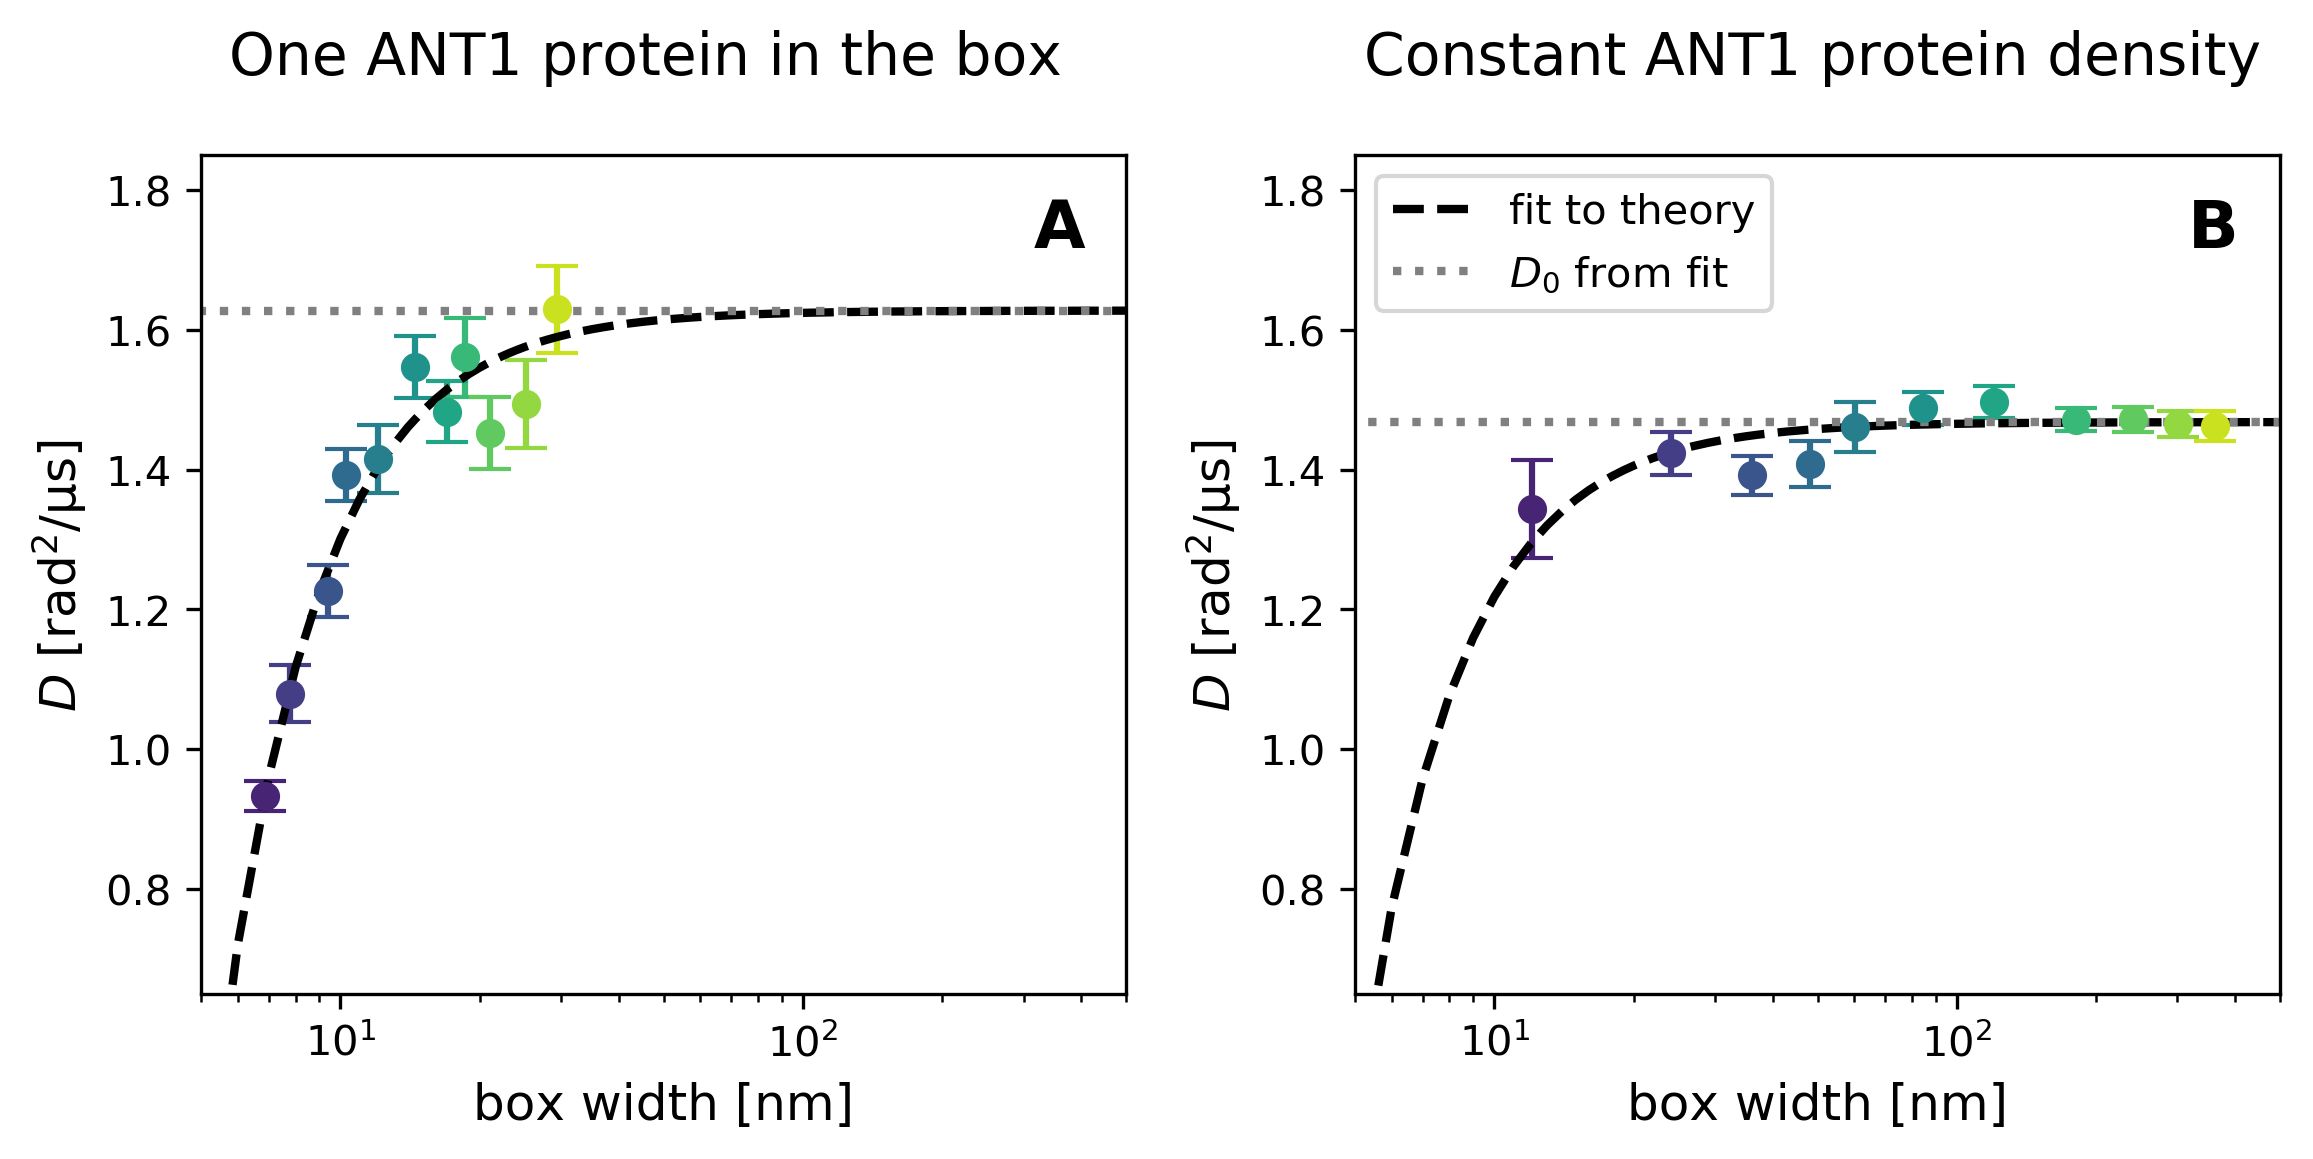

In [16]:
fig, ax = plt.subplots(1,2, figsize=[8,4], dpi=300)

# Diffusion coefficients
for i in range(len(old_edge_av)):
    ax[1].errorbar(old_edge_av[i],old_dc_av[i]*1e6,yerr=old_err_av[i]*1e6,ls='none',marker='o',capsize=5,c=old_cmap(0.1+0.9*float(i)/len(old_edge_av)))
for j in range(len(new_edge_av)):
    ax[0].errorbar(new_edge_av[j],new_dc_av[j]*1e6,yerr=new_err_av[j]*1e6,ls='none',marker='o',capsize=5,c=new_cmap(0.1+0.9*float(j)/len(new_edge_av)))
    
# Fit to theory and limiting value
xax = np.arange(501)
ax[1].plot(xax[1:],dc_rot_theory(xax[1:],old_rad_opt,old_dc0_opt)*1e6,c='black',linestyle='--',lw=2,label='fit to theory')
ax[0].plot(xax[1:],dc_rot_theory(xax[1:],new_rad_opt,new_dc0_opt)*1e6,c='black',linestyle='--',lw=2,label='fit to theory')
ax[1].plot(xax,np.ones(len(xax))*old_dc0_opt*1e6,c='gray',linestyle=':',lw=2,label=r'$D_0$ from fit')
ax[0].plot(xax,np.ones(len(xax))*new_dc0_opt*1e6,c='gray',linestyle=':',lw=2,label=r'$D_0$ from fit')

# Titles
title0 = ax[0].text(0.03,1.15,'One ANT1 protein in the box',   transform=ax[0].transAxes, fontsize=14, va='top',color='black')
title1 = ax[1].text(0.01,1.15,'Constant ANT1 protein density', transform=ax[1].transAxes, fontsize=14, va='top',color='black')
ax[1].legend(loc='upper left')

# Axis options
for axi in ax:
    #axi.set_facecolor('lightgray')
    axi.set_alpha(0.5)
    axi.set_xscale('log')
    axi.set_xlim(5,500)
    #ax[0,0].set_xlim(0,400)
    axi.set_ylim(0.65,1.85)
    axi.set_xlabel(r'box width [nm]',size=12)
    axi.set_ylabel(r'$D$ [rad$^2$/$\mathrm{\mu}$s]',size=12)
    #axi.grid('on')

# Panel labels
ax[0].text(0.9, 0.95, 'A', transform=ax[0].transAxes, fontsize=16, fontweight='bold', va='top')
ax[1].text(0.9, 0.95, 'B', transform=ax[1].transAxes, fontsize=16, fontweight='bold', va='top')

fig.tight_layout()

fig.savefig( 'rotational_diffusion_ANT1.pdf', bbox_inches='tight', bbox_extra_artists=(title1,title0), dpi=300 )